In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gc


In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
building = pd.read_csv("building_metadata.csv")
weather_train = pd.read_csv("weather_train.csv")
weather_test = pd.read_csv("weather_test.csv")

In [4]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();


In [33]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int64
meter                 int64
timestamp             object
meter_reading         float64
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtypes: float64(10), int64(4), object(2)
memory usage: 5.0 GB


In [5]:

d_types = {'building_id': np.uint8,
          'meter': np.uint8,
          'site_id': np.uint8,
          'primary_use': 'category',
          'square_feet': np.uint8,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float16,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float16,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float16,
          'wind_direction': np.float16,
          'wind_speed': np.float16}

In [6]:

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    

In [24]:

train.info(memory_usage='deep')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           uint8
meter                 uint8
timestamp             object
meter_reading         float64
site_id               uint8
primary_use           category
square_feet           uint8
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: category(1), float16(9), float64(1), object(1), uint8(4)
memory usage: 2.2 GB


In [7]:
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect()

0

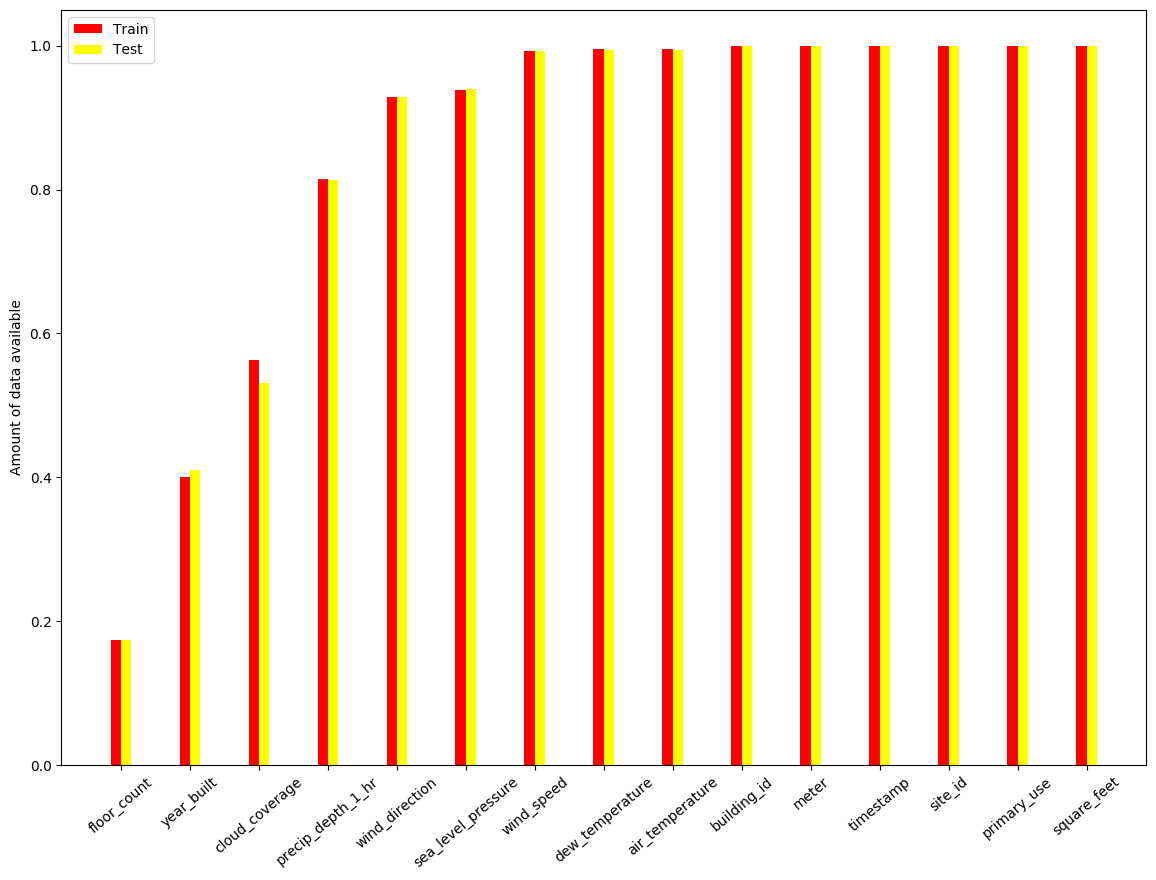

In [9]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.15

fig, axes = plt.subplots(1,1,figsize=(14, 10), dpi=100)
tr = axes.bar(ind, train_data, width, color='red')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='yellow')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);


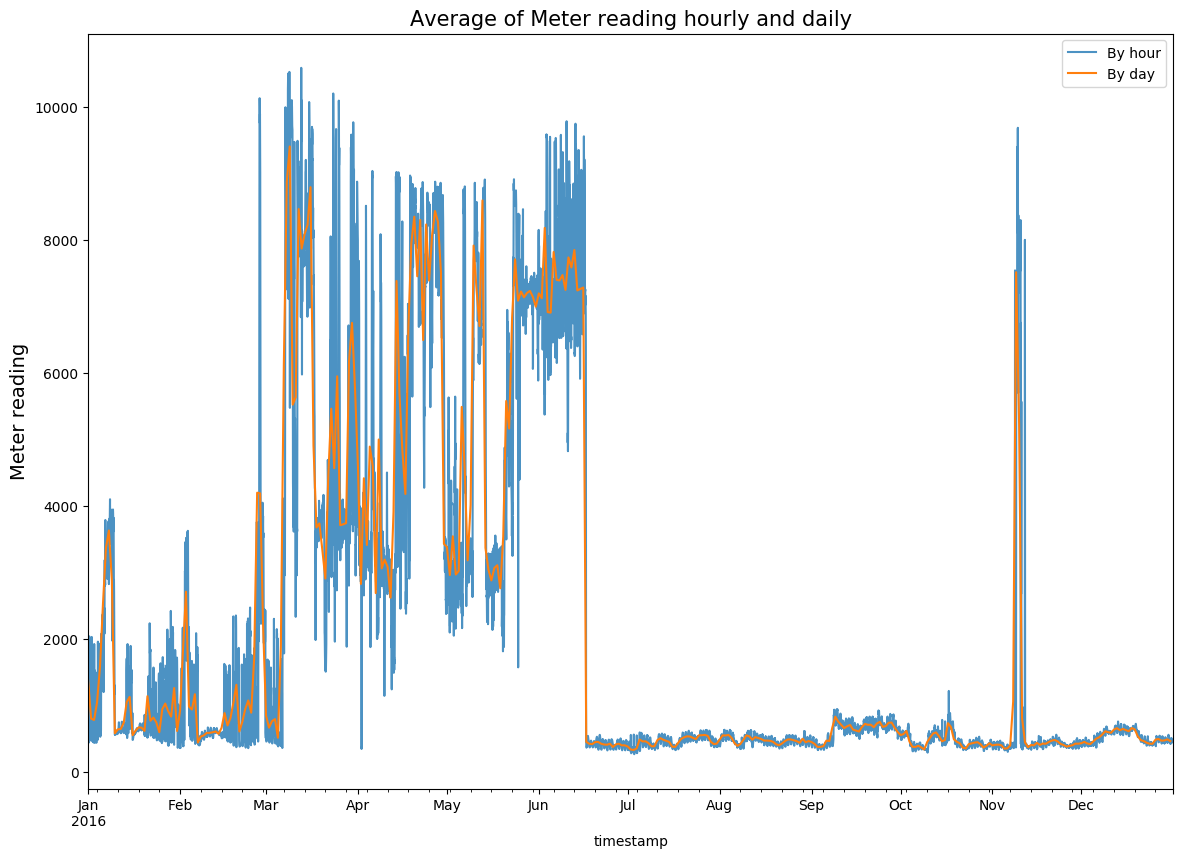

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(14, 10), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Average of Meter reading hourly and daily', fontsize=15);
axes.legend();

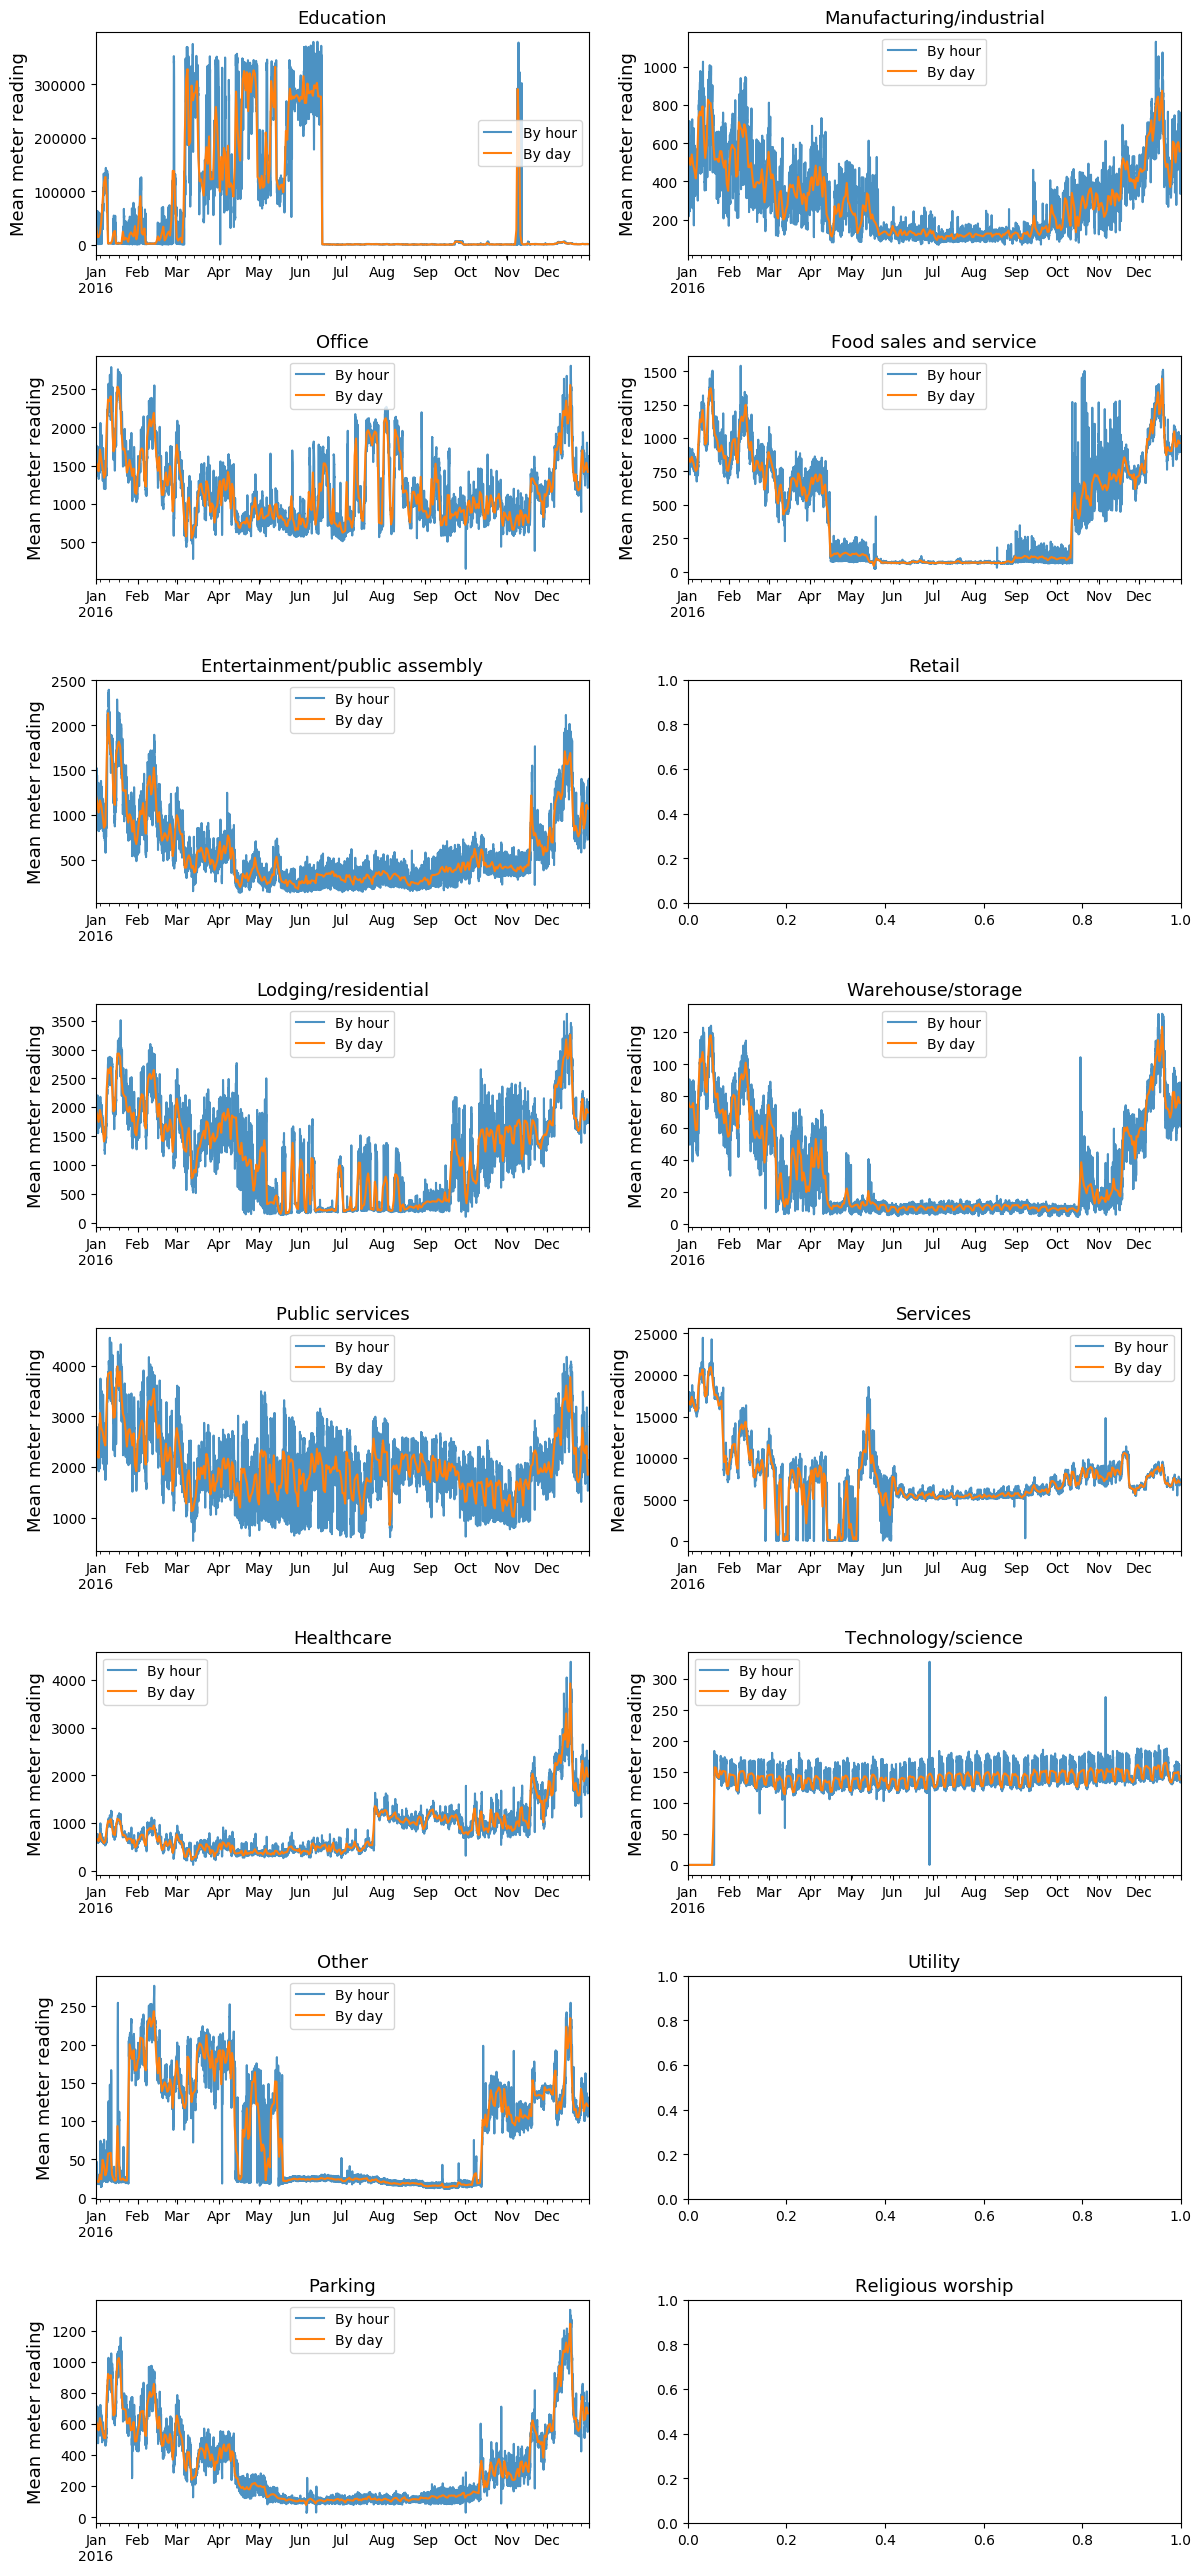

In [58]:
fig, axes = plt.subplots(8,2,figsize=(14, 33), dpi=100)
for i, use in enumerate(train['primary_use'].value_counts().index.to_list()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

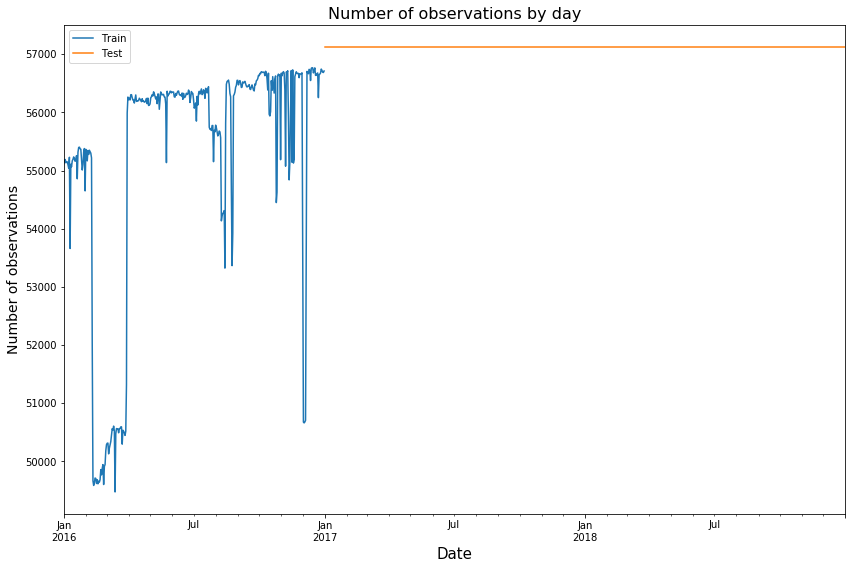

In [59]:
fig, axes = plt.subplots(1, 1, figsize=(14, 9))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=15);
test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

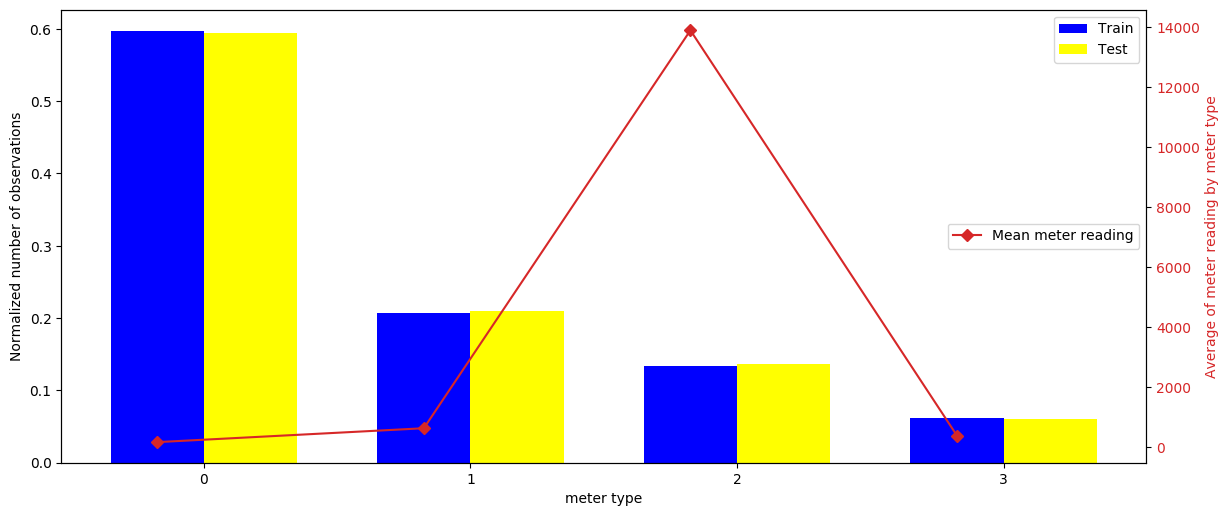

In [61]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='blue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='yellow')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:red', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:red');
axes2.set_ylabel('Average of meter reading by meter type', color='tab:red');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

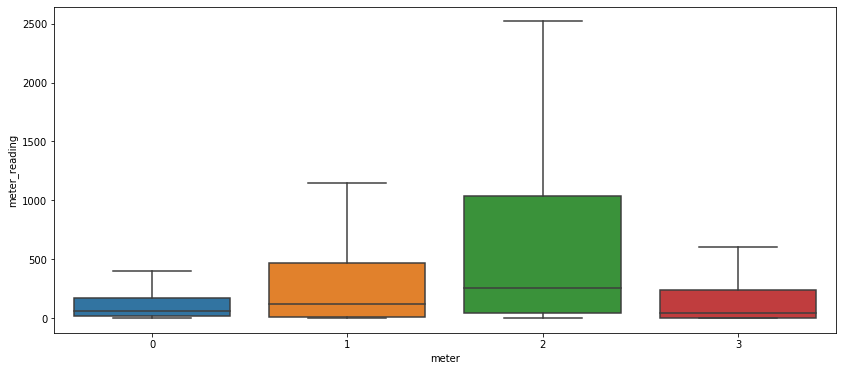

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

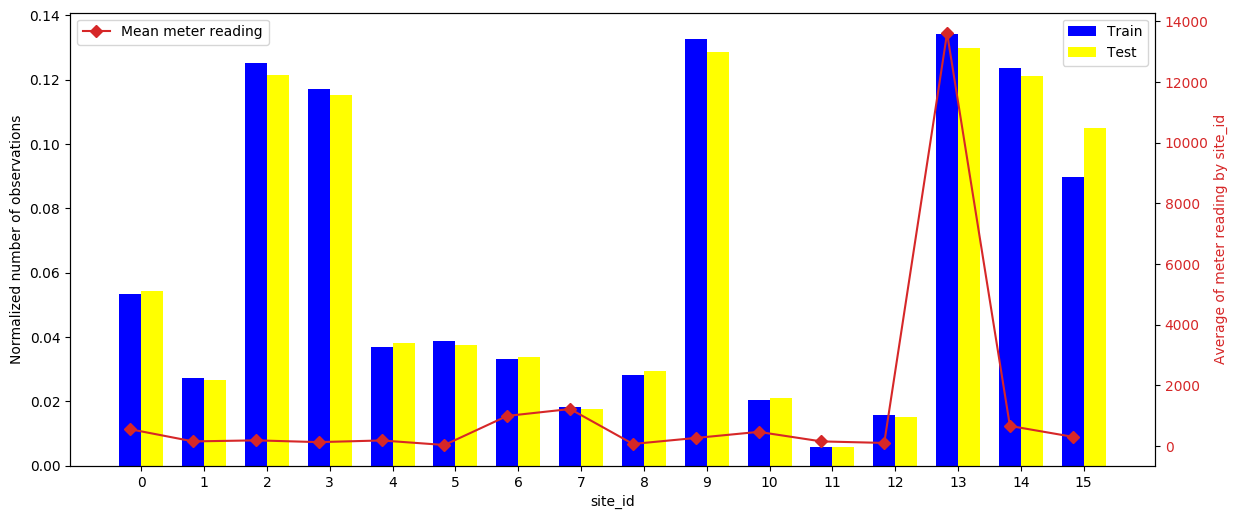

In [62]:
train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='blue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='yellow')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:red', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:red');
axes2.set_ylabel('Average of meter reading by site_id', color='tab:red');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

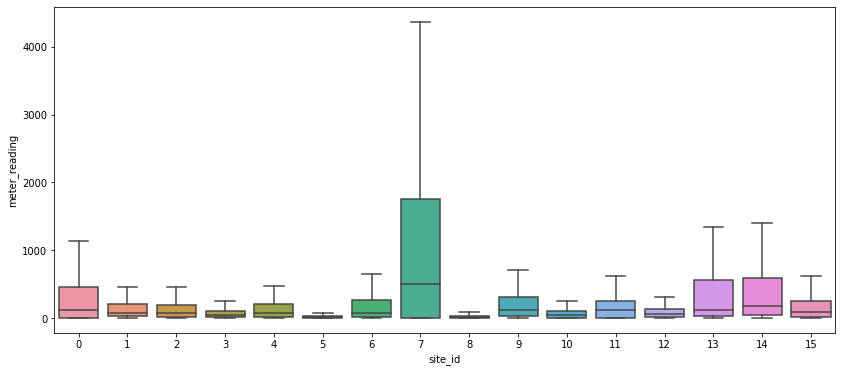

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

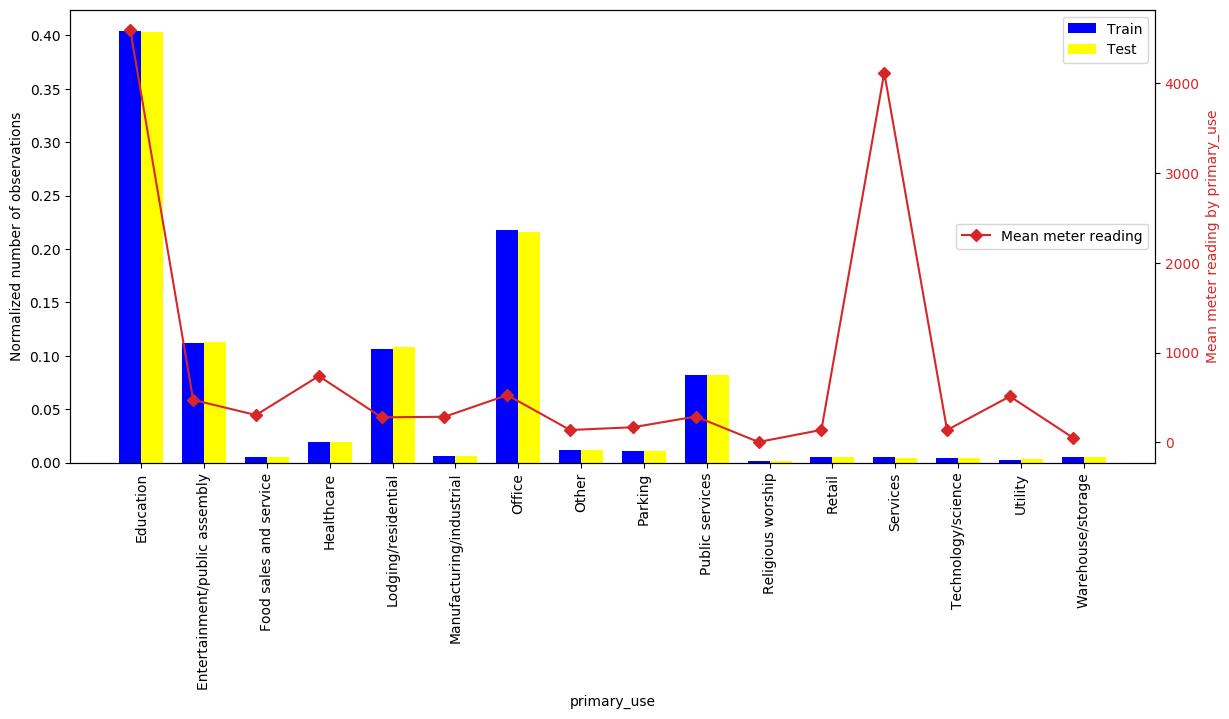

In [64]:
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='blue')

test_data = test['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='yellow')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:red', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:red');
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:red');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

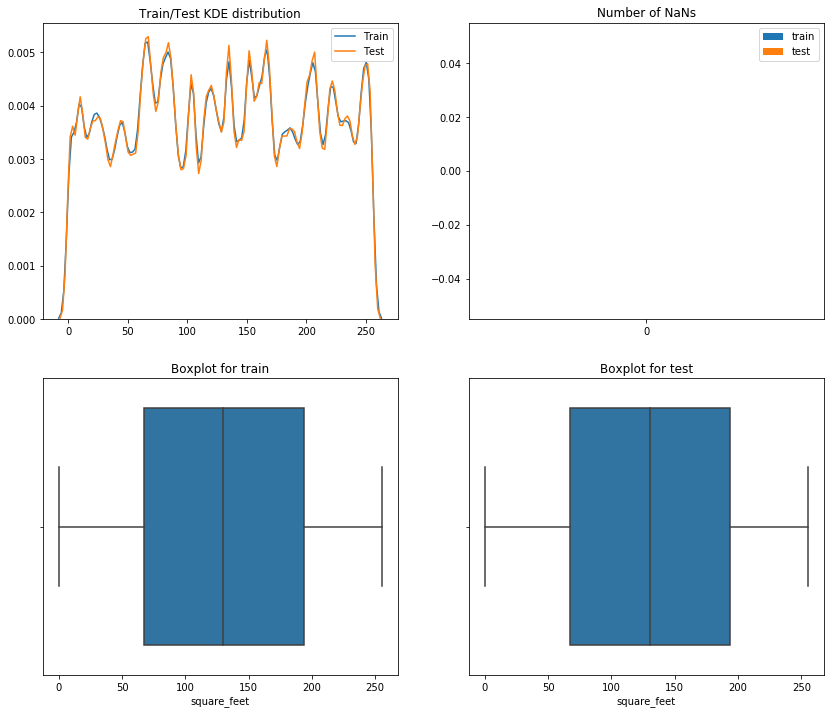

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

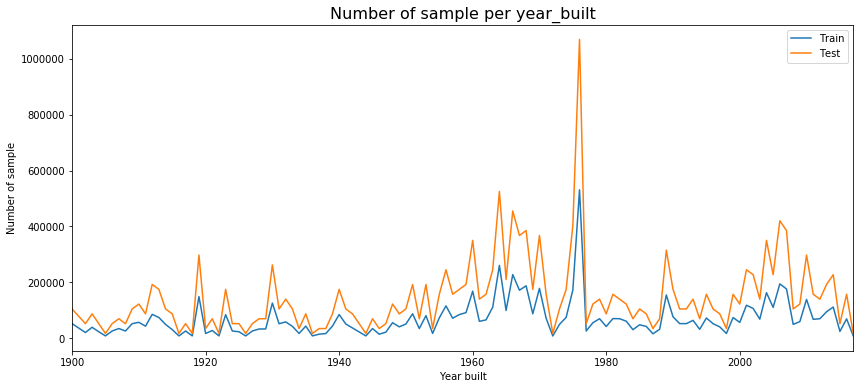

In [65]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('Year built');
test['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_ylabel('Number of sample');
axes.legend(['Train', 'Test']);
axes.set_title('Number of sample per year_built', fontsize=16);

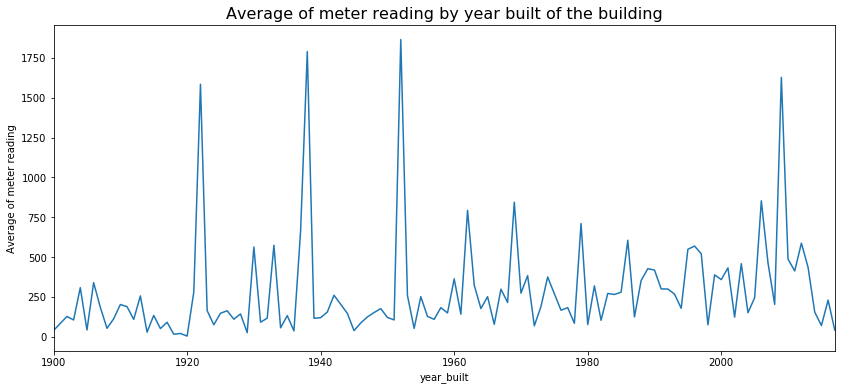

In [66]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Average of meter reading');
axes.set_title('Average of meter reading by year built of the building', fontsize=16);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


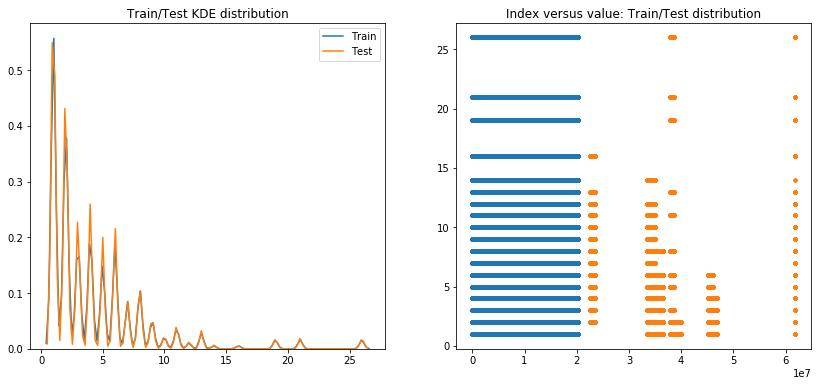

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(train['floor_count'], label='Train', ax=axes[0]);
sns.kdeplot(test['floor_count'], label='Test', ax=axes[0]);
test.index += len(train)
axes[1].plot(train['floor_count'], '.', label='Train');
axes[1].plot(test['floor_count'], '.', label='Test');
test.index -= len(train)
axes[0].set_title('Train/Test KDE distribution');
axes[1].set_title('Index versus value: Train/Test distribution');
gc.collect();

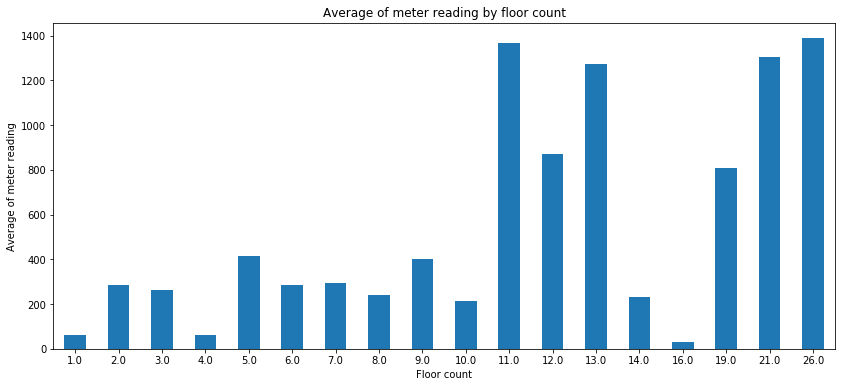

In [68]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
pd.Series(index=train['floor_count'].value_counts().index, 
          data=train.groupby('floor_count')['meter_reading'].transform('mean').value_counts().index).sort_index().plot(kind='bar', rot=0, ax=axes);
axes.set_xlabel('Floor count');
axes.set_ylabel('Average of meter reading');
axes.set_title('Average of meter reading by floor count');

In [51]:
train['hour'] = train['timestamp'].dt.hour
test['hour'] = test['timestamp'].dt.hour

In [ ]:
train_data = train['hour'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='blue')

test_data = test['hour'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='yellow')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['hour'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['hour', 'meter_reading']].groupby('hour')['meter_reading'].mean().sort_index().values, 'D-', color='tab:red', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:red');
axes2.set_ylabel('Mean meter reading by hour', color='tab:red');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

In [53]:
train['day'] = train['timestamp'].dt.day
test['day'] = test['timestamp'].dt.day

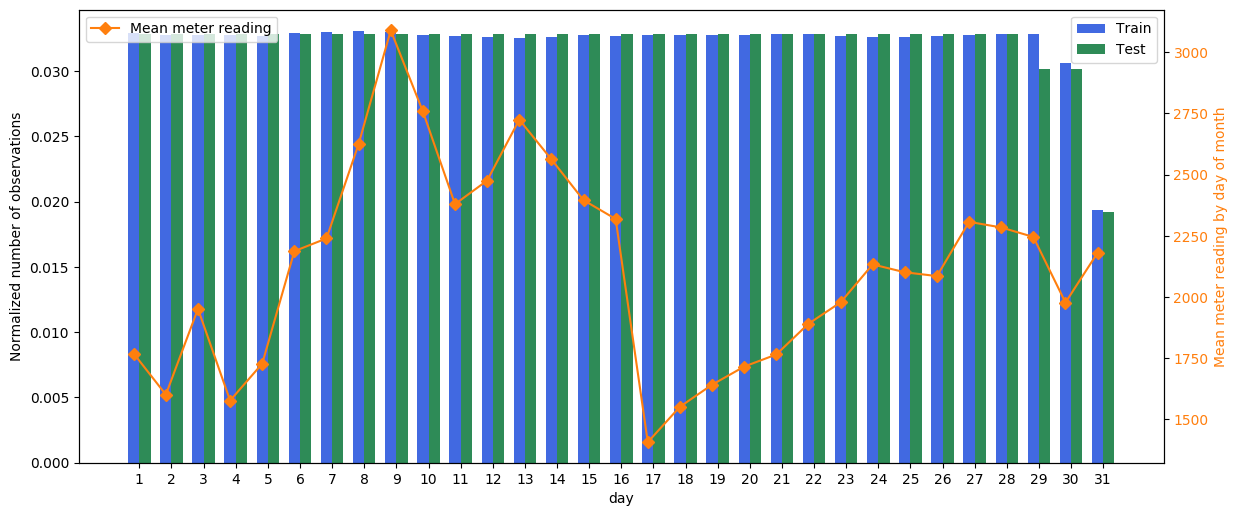

In [54]:
train_data = train['day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['day'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['day', 'meter_reading']].groupby('day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

In [55]:
train['weekday'] = train['timestamp'].dt.weekday
test['weekday'] = test['timestamp'].dt.weekday

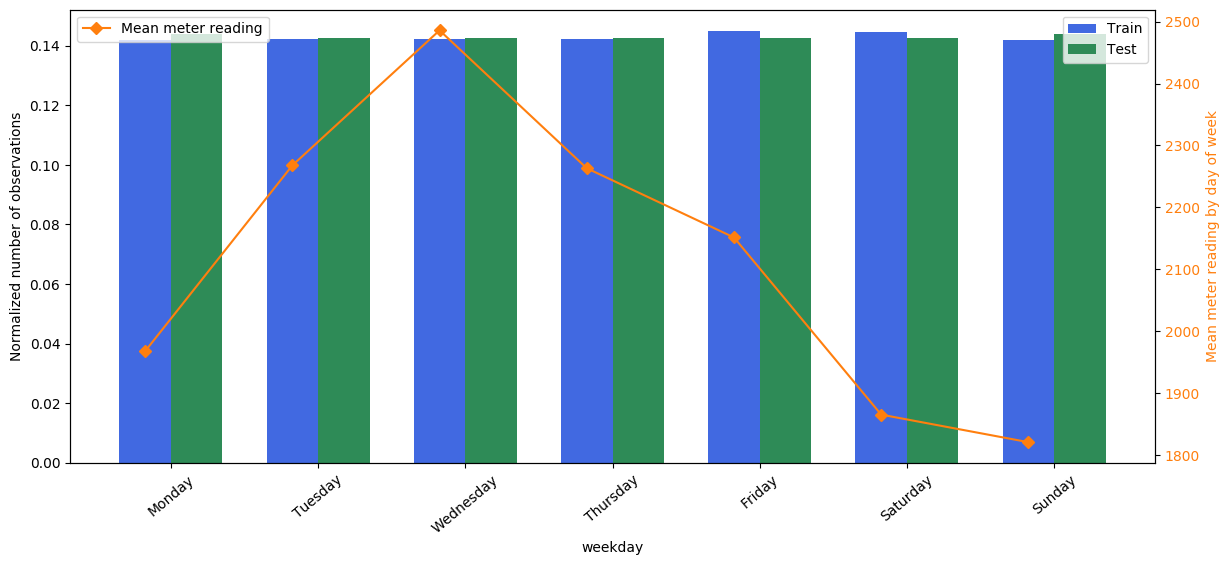

In [56]:
train_data = train['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['weekday', 'meter_reading']].groupby('weekday')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(train['weekday'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);